In [7]:
import pandas as pd

data = pd.read_csv('D:\AIML\WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(data.head())

print(data.info())

# Check for missing values
print(data.isnull().sum())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
C:\Users\kshit\AppData\Local\Temp\ipykernel_11084\3250710015.py:3: SyntaxWarning: invalid escape sequence '\A'
  data = pd.read_csv('D:\AIML\WA_Fn-UseC_-Telco-Customer-Churn.csv')


       SeniorCitizen     tenure  MonthlyCharges  TotalCharges
count            9.0   9.000000        9.000000      9.000000
mean             0.0  16.888889       64.105556   1126.416667
std              0.0  16.026887       28.664574   1084.998286
min              0.0   1.000000       29.750000     29.850000
25%              0.0   2.000000       42.300000    151.650000
50%              0.0  10.000000       56.950000    820.500000
75%              0.0  28.000000       89.100000   1889.500000
max              0.0  45.000000      104.800000   3046.050000


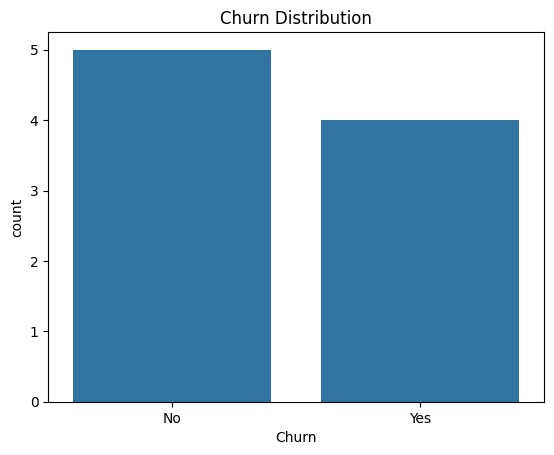

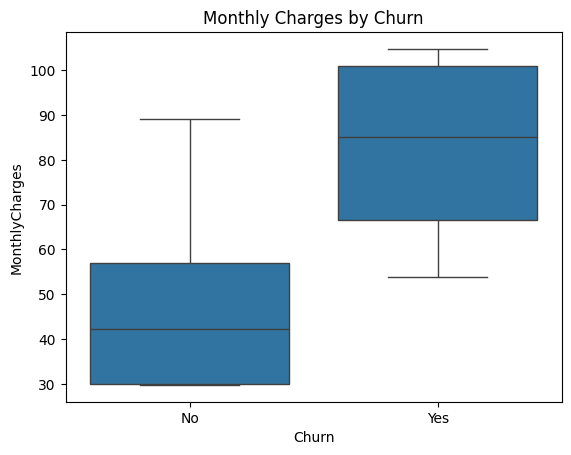

In [8]:
# Statistical summary
print(data.describe())

# Visualize categorical features
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot for churn
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.show()

# Visualizing numerical features
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title('Monthly Charges by Churn')
plt.show()

In [9]:
print(data[['tenure', 'MonthlyCharges', 'TotalCharges']].dtypes)

tenure              int64
MonthlyCharges    float64
TotalCharges      float64
dtype: object


In [10]:
# Convert to numeric, coercing any errors
data['tenure'] = pd.to_numeric(data['tenure'], errors='coerce')
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Drop any rows that resulted in NaN from the conversion
data.dropna(subset=['tenure', 'MonthlyCharges', 'TotalCharges'], inplace=True)

In [11]:
print(data[['tenure', 'MonthlyCharges', 'TotalCharges']].dtypes)

tenure              int64
MonthlyCharges    float64
TotalCharges      float64
dtype: object


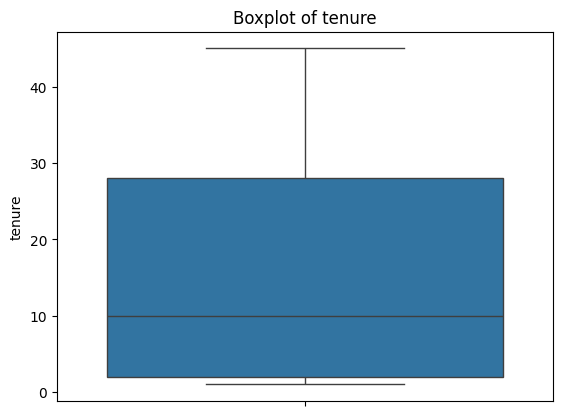

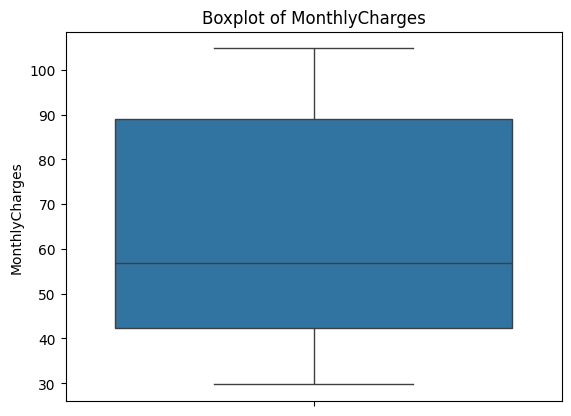

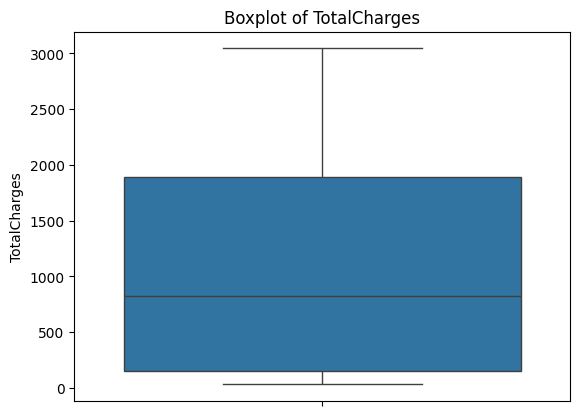

In [12]:
# Boxplots to check for outliers
for column in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

# Handling outliers (capping)
for column in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower_bound, upper_bound)

In [13]:
# One-hot encoding for categorical variables
data = pd.get_dummies(data, drop_first=True)

# Display the updated dataframe
print(data.head())

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  customerID_3668-QPYBK  \
0              0       1           29.85         29.85                  False   
1              0      34           56.95       1889.50                  False   
2              0       2           53.85        108.15                   True   
3              0      45           42.30       1840.75                  False   
4              0       2           70.70        151.65                  False   

   customerID_5575-GNVDE  customerID_6713-OKOMC  customerID_7590-VHVEG  \
0                  False                  False                   True   
1                   True                  False                  False   
2                  False                  False                  False   
3                  False                  False                  False   
4                  False                  False                  False   

   customerID_7795-CFOCW  customerID_7892-POOKP  ...  DeviceProtecti

In [15]:
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = data.drop('Churn_Yes', axis=1)  # Adjust based on one-hot encoding
y = data['Churn_Yes']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_scaled)

# Display the shape of reduced features
print(X_pca.shape)

(9, 8)


In [19]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Check the class distribution before SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(y).value_counts())

# Apply SMOTE with a reduced number of neighbors (if needed)
smote = SMOTE(random_state=42, k_neighbors=3)  # Use 3 neighbors (or lower)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution before SMOTE:
Churn_Yes
False    5
True     4
Name: count, dtype: int64
Class distribution after SMOTE:
Churn_Yes
False    5
True     5
Name: count, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1
        True       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



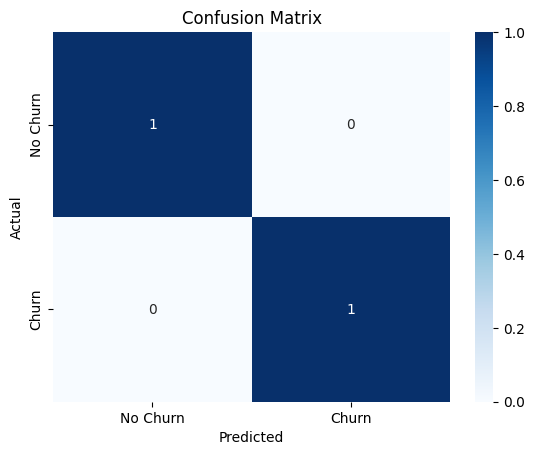

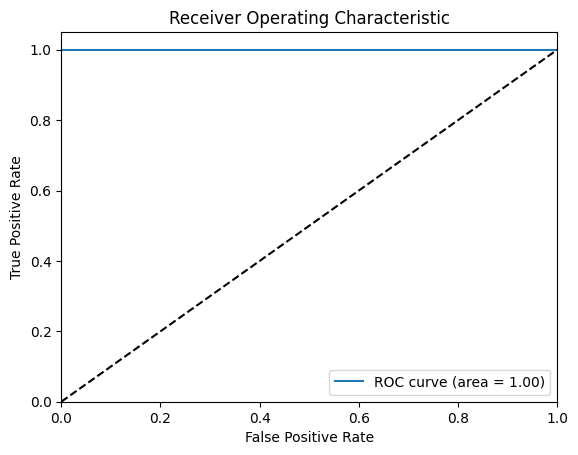

Number of features: 30
Number of importances: 8
Feature names and importances lengths do not match!


In [22]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pandas as pd

# Assuming your model is already trained and predictions are made:
# y_test - Actual values (true labels)
# y_pred - Predicted values (predicted labels from the model)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
importances = model.feature_importances_  # Feature importances from your model
feature_names = X.columns  # Assuming X is your feature DataFrame

# Check lengths of feature names and importances
print("Number of features:", len(feature_names))
print("Number of importances:", len(importances))

# Ensure both arrays have the same length before creating the DataFrame
if len(feature_names) == len(importances):
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.show()
else:
    print("Feature names and importances lengths do not match!")
